# PSM-XGBoost

To solve the problem of endogeneity, use propensity score matching (PSM) combined with XGBoost to analyze the Internet usage

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier, XGBRegressor

## Load and Make Datasets

In [4]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [5]:
Df = pd.read_parquet(Df_Filename)

In [6]:
Df.shape

(798604, 74)

In [7]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [8]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

### One-hot & Shuffle Conversion

In [9]:
print(Df['COUNTRY_ISO3'].dtype)

object


In [10]:
# 对 COUNTRY_ISO3 进行 one-hot 编码
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
country_encoded = onehot_encoder.fit_transform(Df[['COUNTRY_ISO3']])
country_columns = onehot_encoder.get_feature_names_out(['COUNTRY_ISO3'])

In [11]:
# 创建一个新的 DataFrame，包含 one-hot 编码后的国家列
country_df = pd.DataFrame(country_encoded, columns=country_columns, index=Df.index)

In [12]:
Df_new = pd.concat([Df.drop('COUNTRY_ISO3', axis=1), country_df], axis=1)

In [13]:
Df_new = Df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
Df_new.shape

(798604, 224)

In [15]:
Df_new.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,COUNTRY_ISO3_USA,COUNTRY_ISO3_UZB,COUNTRY_ISO3_VEN,COUNTRY_ISO3_VNM,COUNTRY_ISO3_XKX,COUNTRY_ISO3_XNC,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE
0,13,5278.624306,3.0,1.0,1.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,14,0.000000,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,5345.822529,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,17,10127.215850,5.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,16,7106.753699,6.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Propensity Score Matching (XGBClassifier)

### 1. Data preprocessing: removing specific features

In [16]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 
                      'Sadness', 'Home_handline', 'Mobile_phone', 'Stress', 'Anger', 'Donated', 'Volunteer', 'Help_stranger',
                     'Religion_importance', 'Children_respected', 'Women_respected']
Df_new = Df_new.drop(columns=features_to_remove)

In [17]:
Df_new.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Living_standard_trend', 'Enough_food', 'Enough_shelter', 'Well_rested',
       'Respected',
       ...
       'COUNTRY_ISO3_USA', 'COUNTRY_ISO3_UZB', 'COUNTRY_ISO3_VEN',
       'COUNTRY_ISO3_VNM', 'COUNTRY_ISO3_XKX', 'COUNTRY_ISO3_XNC',
       'COUNTRY_ISO3_YEM', 'COUNTRY_ISO3_ZAF', 'COUNTRY_ISO3_ZMB',
       'COUNTRY_ISO3_ZWE'],
      dtype='object', length=207)

### 2. Prepare data

In [18]:
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 3. Optimization parameters

In [22]:
def optimize_xgb_params(X_train, y_train):
    param_space = {
        'n_estimators': Integer(100, 5000),
        'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
        'max_depth': Integer(3, 16),
        'subsample': Real(0.5, 1.0),
        'min_child_weight': Real(0.001, 10, prior='log-uniform'),
        'max_delta_step': Real(0.001, 10, prior='log-uniform'),
        'reg_lambda': Real(0.001, 10, prior='log-uniform'),
        'reg_alpha': Real(0.001, 10, prior='log-uniform'),
        'gamma': Real(0.001, 10, prior='log-uniform')
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic', device='cuda', tree_method='hist', random_state=42)
    
    bayes_search = BayesSearchCV(
        estimator=xgb_model,
        search_spaces=param_space,
        n_iter=50,  
        cv=10,
        scoring='roc_auc',
        n_jobs=1,
        verbose=2,
        random_state=42
    )
    
    bayes_search.fit(X_train, y_train)
    
    print("Best parameters:", bayes_search.best_params_)
    print("Best ROC AUC score:", bayes_search.best_score_)
    
    return bayes_search.best_estimator_

best_model = optimize_xgb_params(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  53.8s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  53.4s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  52.9s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_del

Best parameters: OrderedDict([('gamma', 0.0013046378568408467), ('learning_rate', 0.031124013450129717), ('max_delta_step', 0.4845553927498424), ('max_depth', 9), ('min_child_weight', 0.001), ('n_estimators', 3468), ('reg_alpha', 2.9151430642575065), ('reg_lambda', 0.006393503525150652), ('subsample', 0.546668978508578)])

### 4. Evaluate the best model

In [24]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8441
Test ROC AUC: 0.9145


### 5. Estimating propensity scores

In [25]:
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

### 6. Print propensity score statistics

In [26]:
print("\nPropensity Score Statistics:")
print(Df_new['propensity_score'].describe())

print("\nPropensity Score Statistics for Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'].describe())

print("\nPropensity Score Statistics for No Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'].describe())


Propensity Score Statistics:
count    798604.000000
mean          0.676001
std           0.337737
min           0.000875
25%           0.374114
50%           0.834931
75%           0.972947
max           0.999860
Name: propensity_score, dtype: float64

Propensity Score Statistics for Internet Access Group:
count    539754.000000
mean          0.855431
std           0.195798
min           0.007768
25%           0.804710
50%           0.945462
75%           0.986353
max           0.999860
Name: propensity_score, dtype: float64

Propensity Score Statistics for No Internet Access Group:
count    258850.000000
mean          0.301854
std           0.254673
min           0.000875
25%           0.091492
50%           0.219850
75%           0.462360
max           0.999104
Name: propensity_score, dtype: float64


### 6. Visualizing Propensity Score Distribution

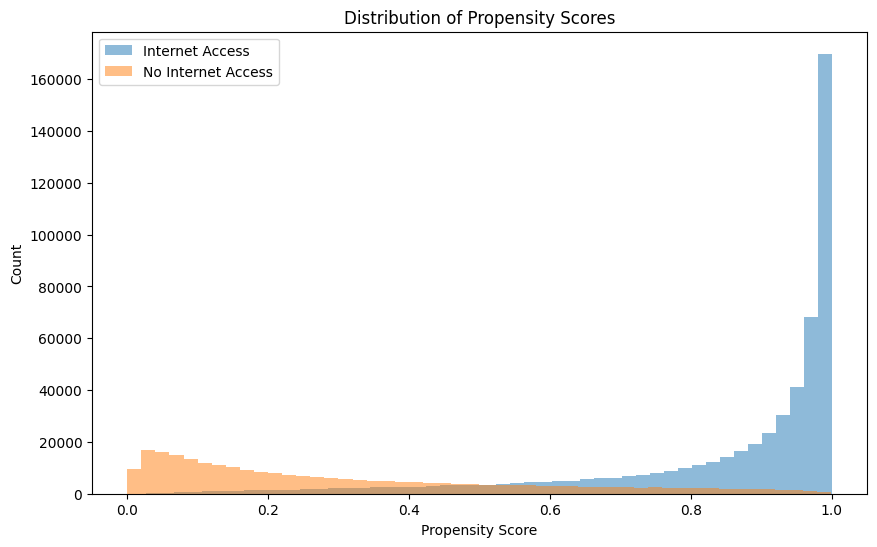

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()

### 7. Optimized sample matching function

In [55]:
from sklearn.neighbors import BallTree

Total matched pairs: 141210
Unique control samples used: 141210

Distribution of control sample usage:
1    141210
Name: count, dtype: int64


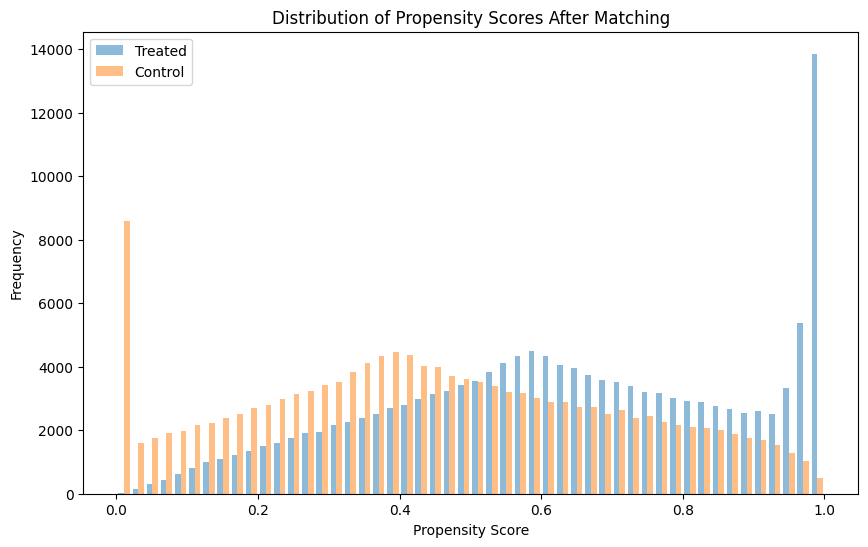

In [56]:
def match_samples_many_to_one_efficient(df, caliper=0.2, max_matches=1, n_jobs=-1, batch_size=10000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用BallTree进行高效的近邻搜索
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    # 批处理
    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        
        # 找到半径内的所有邻居
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break  # 找到匹配后跳出内循环

    # 创建匹配后的数据框
    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    # 统计信息
    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    # 可视化匹配质量
    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

# 使用函数
matched_df = match_samples_many_to_one_efficient(Df_new)

In [57]:
# 输出匹配后的样本数
print(f"\nFinal matched sample size: {len(matched_df)}")


Final matched sample size: 282420


In [58]:
matched_treated_count = len(matched_df[matched_df['Internet_access_available'] == 0])
print(f"Number of Matched Treated Samples: {matched_treated_count}")

Number of Matched Treated Samples: 141210


### 8. Balance test(Standardized Mean Differences)

In [59]:
# 平衡性检验函数
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

# 定义需要检验的变量
variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

# 计算匹配前的SMD
smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')

# 计算匹配后的SMD
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

# 将SMD结果输出为DataFrame
smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})

print(smd_df)

             Variable  SMD Before  SMD After
0                wave    0.333406   0.098685
1            INCOME_2    0.511280   0.126174
2      Cantril_ladder    0.521002   0.180874
3      Health_disable   -0.417950  -0.115965
4       Relative_have    0.397612   0.111052
..                ...         ...        ...
201  COUNTRY_ISO3_XNC    0.095724   0.013025
202  COUNTRY_ISO3_YEM   -0.068147  -0.014934
203  COUNTRY_ISO3_ZAF   -0.009811  -0.004033
204  COUNTRY_ISO3_ZMB   -0.061810  -0.012505
205  COUNTRY_ISO3_ZWE   -0.051431  -0.015686

[206 rows x 3 columns]


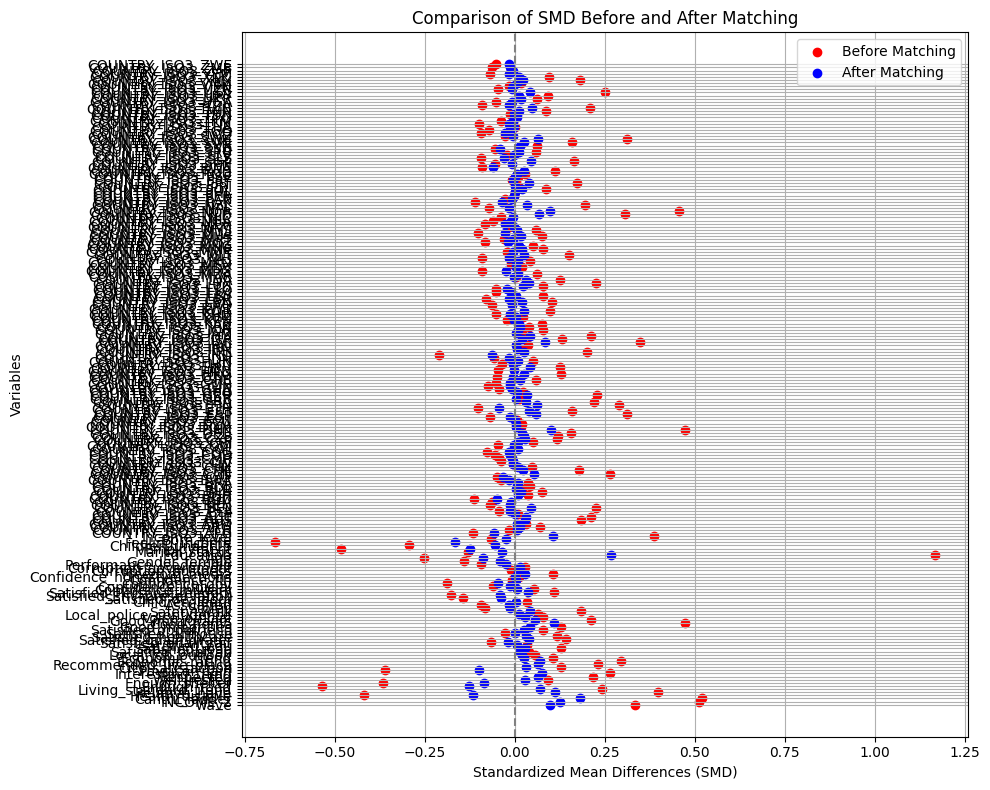

In [60]:
# 绘制匹配前后的SMD对比图
plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

### 9. Group analysis

In [61]:
# 定义参数空间
param_space = {
    'n_estimators': Integer(100, 5000),
        'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
        'max_depth': Integer(3, 16),
        'subsample': Real(0.5, 1.0),
        'min_child_weight': Real(0.001, 10, prior='log-uniform'),
        'max_delta_step': Real(0.001, 10, prior='log-uniform'),
        'reg_lambda': Real(0.001, 10, prior='log-uniform'),
        'reg_alpha': Real(0.001, 10, prior='log-uniform'),
        'gamma': Real(0.001, 10, prior='log-uniform')
}

# 处理有互联网访问的组
treated = matched_df[matched_df['Internet_access_available'] == 1]
X_treated = treated.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
y_treated = treated['Cantril_ladder']

X_train_treated, X_test_treated, y_train_treated, y_test_treated = train_test_split(X_treated, y_treated, test_size=0.1, random_state=42)

# 初始化XGBoost模型（有互联网组）
xgb_model_treated = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', random_state=42)

# 使用BayesSearchCV进行参数优化（有互联网组）
bayes_search_treated = BayesSearchCV(
    estimator=xgb_model_treated,
    search_spaces=param_space,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 拟合模型（有互联网组）
bayes_search_treated.fit(X_train_treated, y_train_treated)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  17.3s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  16.7s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  16.3s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_del

BayesSearchCV(cv=10,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [62]:
# 打印最佳参数和交叉验证得分（有互联网组）
print("Best parameters for Internet Access group:", bayes_search_treated.best_params_)
print("Best cross-validation R-squared score for Internet Access group:", bayes_search_treated.best_score_)


Best parameters for Internet Access group: OrderedDict([('gamma', 0.0010340016434251915), ('learning_rate', 0.04321753967138224), ('max_delta_step', 0.9228497044562662), ('max_depth', 6), ('min_child_weight', 0.20637512290600768), ('n_estimators', 1446), ('reg_alpha', 0.017838454498583057), ('reg_lambda', 0.0040773533275832545), ('subsample', 0.9469190305262598)])
Best cross-validation R-squared score for Internet Access group: 0.26819912489318504


0.15 1
Best parameters for Internet Access group: OrderedDict([('gamma', 0.0010340016434251915), ('learning_rate', 0.04321753967138224), ('max_delta_step', 0.9228497044562662), ('max_depth', 6), ('min_child_weight', 0.20637512290600768), ('n_estimators', 1446), ('reg_alpha', 0.017838454498583057), ('reg_lambda', 0.0040773533275832545), ('subsample', 0.9469190305262598)])

Best Train R-squared score for Internet Access group: 0.3901
Test R-squared score for Internet Access group: 0.2583


In [63]:
# 使用最佳模型进行预测（有互联网组）
best_model_treated = bayes_search_treated.best_estimator_

In [64]:
# 计算并打印最佳训练R²
y_train_pred_treated = best_model_treated.predict(X_train_treated)
r2_train_treated = r2_score(y_train_treated, y_train_pred_treated)
print(f"Best Train R-squared score for Internet Access group: {r2_train_treated:.4f}")

# 计算并打印测试集R²
y_test_pred_treated = best_model_treated.predict(X_test_treated)
r2_test_treated = r2_score(y_test_treated, y_test_pred_treated)
print(f"Test R-squared score for Internet Access group: {r2_test_treated:.4f}")

Best Train R-squared score for Internet Access group: 0.3897
Test R-squared score for Internet Access group: 0.2556


In [65]:
# 处理没有互联网访问的组（控制组）
control = matched_df[matched_df['Internet_access_available'] == 0]
control_unique = control.drop_duplicates(subset=control.columns.drop('propensity_score'))
X_control = control_unique.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
y_control = control_unique['Cantril_ladder']

X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, test_size=0.1, random_state=42)

In [66]:
# 初始化XGBoost模型（无互联网组）
xgb_model_control = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', random_state=42)

# 使用BayesSearchCV进行参数优化（无互联网组）
bayes_search_control = BayesSearchCV(
    estimator=xgb_model_control,
    search_spaces=param_space,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 拟合模型（无互联网组）
bayes_search_control.fit(X_train_control, y_train_control)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  16.7s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  16.4s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  16.3s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_del

BayesSearchCV(cv=10,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [67]:
# 打印最佳参数和得分（无互联网组）
print("Best parameters for No Internet Access group:", bayes_search_control.best_params_)
print("Best R-squared score for No Internet Access group:", bayes_search_control.best_score_)

# 使用最佳模型进行预测（无互联网组）
best_model_control = bayes_search_control.best_estimator_
y_pred_control = best_model_control.predict(X_test_control)
r2_control = r2_score(y_test_control, y_pred_control)
print(f"Test R-squared score for No Internet Access group: {r2_control:.4f}")

# 计算训练集上的R方分数（无互联网组）
y_train_pred_control = best_model_control.predict(X_train_control)
r2_train_control = r2_score(y_train_control, y_train_pred_control)
print(f"Train R-squared score for No Internet Access group: {r2_train_control:.4f}")

Best parameters for No Internet Access group: OrderedDict([('gamma', 0.001), ('learning_rate', 0.0035776426693020073), ('max_delta_step', 10.0), ('max_depth', 13), ('min_child_weight', 10.0), ('n_estimators', 5000), ('reg_alpha', 10.0), ('reg_lambda', 0.001), ('subsample', 0.5)])
Best R-squared score for No Internet Access group: 0.2464842262519778
Test R-squared score for No Internet Access group: 0.2488
Train R-squared score for No Internet Access group: 0.5066


0.15 1
Best parameters for No Internet Access group: OrderedDict([('gamma', 3.496736542281025), ('learning_rate', 0.028144490035127645), ('max_delta_step', 0.05103976895435888), ('max_depth', 10), ('min_child_weight', 1.4068441349321545), ('n_estimators', 3626), ('reg_alpha', 10.0), ('reg_lambda', 0.012310558641976731), ('subsample', 0.7283699104384492)])
Best R-squared score for No Internet Access group: 0.2384860230807452
Test R-squared score for No Internet Access group: 0.2245
Train R-squared score for No Internet Access group: 0.3254


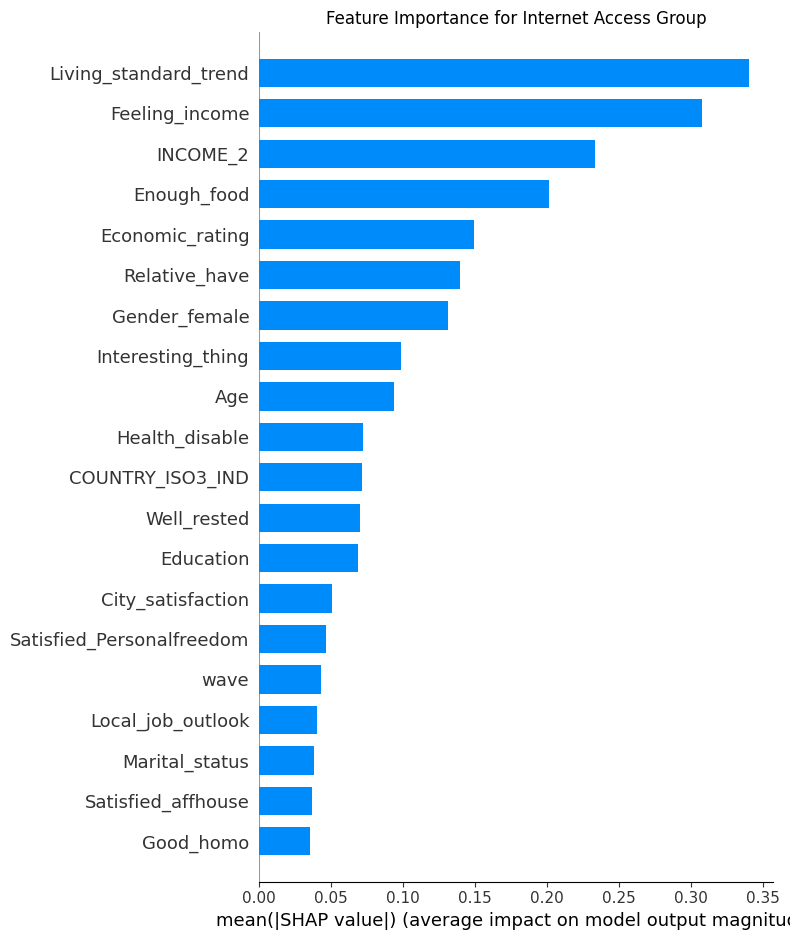

In [68]:



### 10. SHAP value analysis

# 计算SHAP值（有互联网组）
explainer_treated = shap.TreeExplainer(best_model_treated)
shap_values_treated = explainer_treated.shap_values(X_test_treated)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_treated, X_test_treated, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

In [71]:
# 计算SHAP值（无互联网组）
explainer_control = shap.TreeExplainer(best_model_control)
shap_values_control = explainer_control.shap_values(X_test_control)

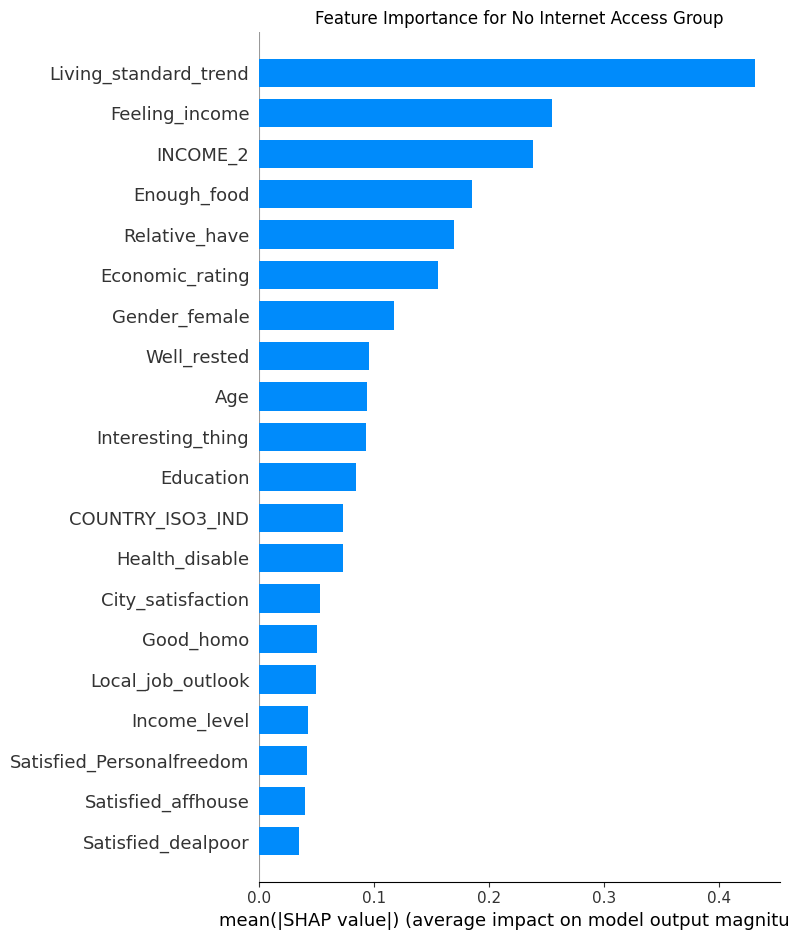

In [72]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_control, X_test_control, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()

### 11. Comparing variable effects

In [64]:
def compare_variable_impact(variable_name):
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(variable_name)]).mean()
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(variable_name)]).mean()
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {impact_with:.4f}")
    print(f"  Without Internet Access: {impact_without:.4f}")
    print(f"  Difference: {impact_with - impact_without:.4f}")

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',  # 经济前景
    'Satisfied_edu', 'Satisfied_healthcare',  # 教育和医疗满意度
    'Voice_official', 'Freedom_media',  # 公民参与和信息自由
    'Children_learn',   # 社会发展指标
    'Safety_walk', 'Confidence_judicial'  # 安全感和制度信心
]
for var in variables_of_interest:
    compare_variable_impact(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2294
  Without Internet Access: 0.2377
  Difference: -0.0083
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0745
  Without Internet Access: 0.0843
  Difference: -0.0098
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0901
  Without Internet Access: 0.0941
  Difference: -0.0041
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0179
  Without Internet Access: 0.0268
  Difference: -0.0089
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0653
  Without Internet Access: 0.0729
  Difference: -0.0075
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0413
  Without Internet Access: 0.0495
  Difference: -0.0082
Impact of Economic_rating on Cantril_ladder:
  With Internet Access: 0.1578
  Without Internet Access: 0.1558
  Difference: 0.0020
Impact of Satisfied_edu on Cantril_ladder:
  With Internet Access: 0.0147
  Without Internet Access: 0.016

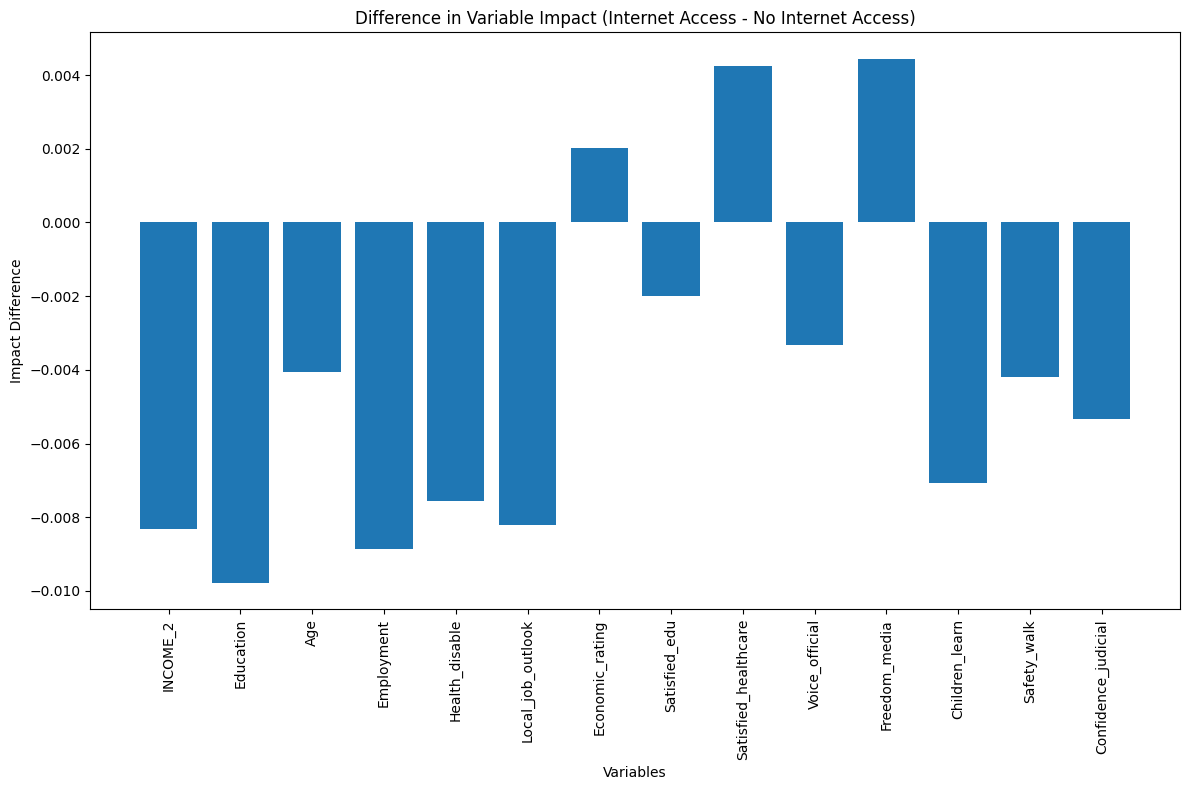

In [65]:
differences = []
for var in variables_of_interest:
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(var)]).mean()
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(var)]).mean()
    differences.append(impact_with - impact_without)

plt.figure(figsize=(12, 8))
plt.bar(variables_of_interest, differences)
plt.xticks(rotation=90)
plt.title("Difference in Variable Impact (Internet Access - No Internet Access)")
plt.xlabel("Variables")
plt.ylabel("Impact Difference")
plt.tight_layout()
plt.show()

### 12. Estimating the overall impact of Internet access

In [66]:
internet_effect = np.mean(matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']) - \
                  np.mean(matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder'])
print(f"Estimated overall effect of internet access on Cantril_ladder: {internet_effect:.4f}")

Estimated overall effect of internet access on Cantril_ladder: 0.3717


### 13.Significance Test

In [67]:
from statsmodels.stats.multitest import multipletests

In [68]:
def compare_variable_impact_with_significance(variable_name):
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(variable_name)])
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(variable_name)])
    
    mean_with = impact_with.mean()
    mean_without = impact_without.mean()
    
    t_stat, p_value = stats.ttest_ind(impact_with, impact_without)
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {mean_with:.4f}")
    print(f"  Without Internet Access: {mean_without:.4f}")
    print(f"  Difference: {mean_with - mean_without:.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    return variable_name, p_value

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',
    'Satisfied_edu', 'Satisfied_healthcare', 'Voice_official', 'Freedom_media',
    'Children_learn', 'Safety_walk', 'Confidence_judicial'
]

# 进行所有变量的显著性测试
results = [compare_variable_impact_with_significance(var) for var in variables_of_interest]

# 使用Bonferroni校正进行多重比较调整
_, adjusted_p_values, _, _ = multipletests([r[1] for r in results], method='bonferroni')

print("\nAdjusted p-values after Bonferroni correction:")
for (var, _), adj_p in zip(results, adjusted_p_values):
    print(f"{var}: {adj_p:.4f}")

# 确定哪些差异在校正后仍然显著
significance_level = 0.05
significant_variables = [var for (var, _), adj_p in zip(results, adjusted_p_values) if adj_p < significance_level]

print("\nVariables with statistically significant differences after correction:")
for var in significant_variables:
    print(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2294
  Without Internet Access: 0.2377
  Difference: -0.0083
  T-statistic: -4.2650
  P-value: 0.0000
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0745
  Without Internet Access: 0.0843
  Difference: -0.0098
  T-statistic: -15.7898
  P-value: 0.0000
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0901
  Without Internet Access: 0.0941
  Difference: -0.0041
  T-statistic: -4.4516
  P-value: 0.0000
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0179
  Without Internet Access: 0.0268
  Difference: -0.0089
  T-statistic: -33.2688
  P-value: 0.0000
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0653
  Without Internet Access: 0.0729
  Difference: -0.0075
  T-statistic: -15.5053
  P-value: 0.0000
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0413
  Without Internet Access: 0.0495
  Difference: -0.0082
  T-statistic: -32.1887
  P-v

## PSM (Random Forest-XGBOOST)

In [16]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 'Sadness']
Df_new = Df_new.drop(columns=features_to_remove)

In [17]:
# 2. 准备数据
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# 3. 优化随机森林参数
def optimize_rf_params(X_train, y_train):
    param_grid = {
        'n_estimators': [500],
        'max_depth': [10],
    
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_rf_params(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 10, 'n_estimators': 500}
Best ROC AUC score: 0.8999067284517722


In [20]:
# 4. 评估最佳模型
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8271
Test ROC AUC: 0.8993


In [21]:
# 5. 估算倾向得分
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

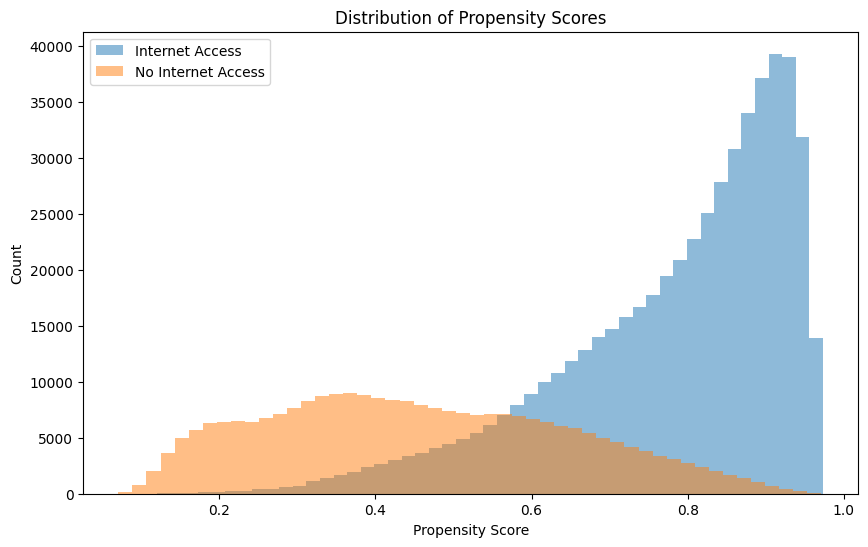

In [22]:
# 6. 可视化倾向得分分布
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()


In [32]:
sd_propensity = Df_new['propensity_score'].std()
recommended_caliper = 0.2 * sd_propensity
print(f"Recommended Caliper (0.2 * SD of propensity scores): {recommended_caliper:.4f}")

Recommended Caliper (0.2 * SD of propensity scores): 0.0447


In [26]:
from sklearn.neighbors import BallTree

Total matched pairs: 323427
Unique control samples used: 114906

Distribution of control sample usage:
1      8010
2      5271
3    101625
Name: count, dtype: int64


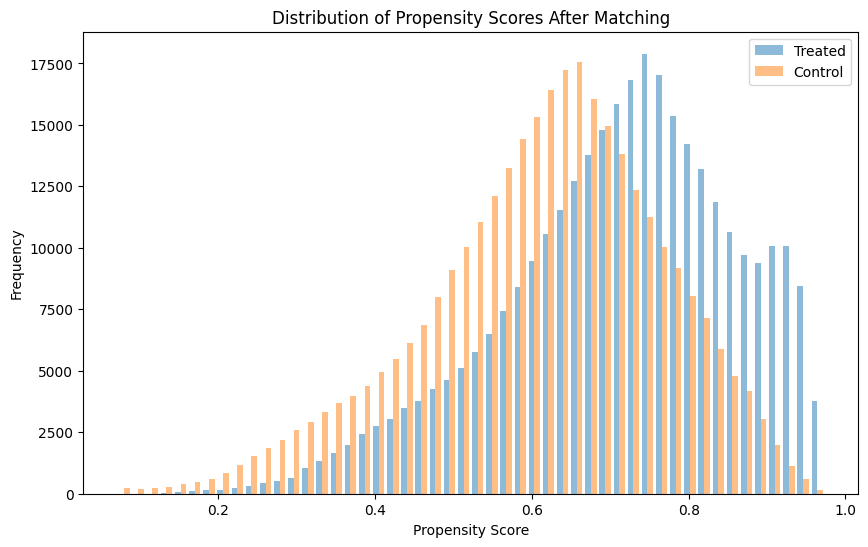

In [39]:
# 7. 多对一匹配
def match_samples_many_to_one_efficient(df, caliper=0.1, max_matches=3, n_jobs=-1, batch_size=12000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break

    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

matched_df = match_samples_many_to_one_efficient(Df_new)

             Variable  SMD Before  SMD After
0                wave    0.333406   0.219404
1            INCOME_2    0.511280   0.116867
2      Cantril_ladder    0.521002   0.192962
3      Health_disable   -0.417950  -0.117964
4       Relative_have    0.397612   0.095405
..                ...         ...        ...
211  COUNTRY_ISO3_XNC    0.095724   0.019784
212  COUNTRY_ISO3_YEM   -0.068147  -0.034988
213  COUNTRY_ISO3_ZAF   -0.009811  -0.024331
214  COUNTRY_ISO3_ZMB   -0.061810  -0.034642
215  COUNTRY_ISO3_ZWE   -0.051431  -0.038074

[216 rows x 3 columns]


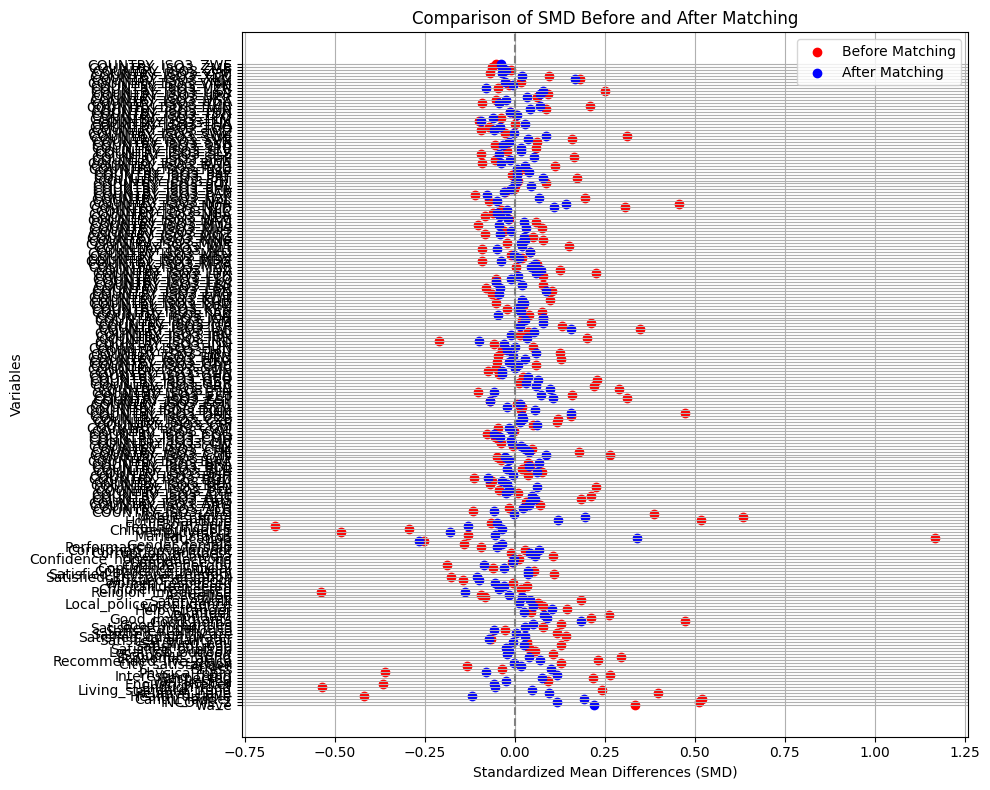

In [40]:
# 8. 平衡性检验
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})
print(smd_df)

plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# 9. 分组分析
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test

model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)

R-squared score for Internet Access: 0.2771
R-squared score for No Internet Access: 0.2578


In [ ]:
# 10. SHAP值分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()
